## Initialize parameters

In [411]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

G=2 # number of networks
N=[4,4] # number of nodes in each network
K=2 # number of commodities
K_weight=[0.5,0.5]
F=2 # number of frequency bands

# matrix of intranetwork links
intranetwork_links_0=np.zeros((N[0],N[0]))
intranetwork_links_1=np.zeros((N[1],N[1]))
intra_links=[intranetwork_links_0,intranetwork_links_1]

# assume we have links 0->1->3 and 0->2->3 for all networks where 3 is the sink
for i in range(0,len(intra_links)):
    intra_links[i][0,1]=1
    intra_links[i][0,2]=1
    intra_links[i][1,3]=1
    intra_links[i][2,3]=1

# links in the networks
link_indices = (np.nonzero(intra_links[0]),np.nonzero(intra_links[1]))
num_links = (np.count_nonzero(intra_links[0]),np.count_nonzero(intra_links[1]))  

# define transmission rate matrix 
# we are assuming that each link is on and can transmit one packet each time step, there are no intra-network interferences!
state=intra_links

# outside arrival probability matrix for each node in the networks (probability that a packet arrives)
# for each commodity 
arrivals_k1=[np.zeros(N[0]),np.zeros(N[1])]
arrivals_k2=[np.zeros(N[0]),np.zeros(N[1])]
# only the first node gets outside arrivals
for j in range(0,len(arrivals_k1)):
    arrivals_k1[j][0]=0.6
    arrivals_k2[j][0]=0

print("There are", G, "networks with", N, "nodes respectively")
print("There are", K, "commodities with",K_weight,"weights resptively")
print("There are", F, "frequency bands and all networks have the same notion of frequency")

There are 2 networks with [4, 4] nodes respectively
There are 2 commodities with [0.5, 0.5] weights resptively
There are 2 frequency bands and all networks have the same notion of frequency


In [3]:
# this function will randomly add an arrival to the queues
def add_arrivals(queues, arrivals):
    # for each network
    for net in range(0,len(queues)):
        for node in range(0,len(queues[net])):
            if np.random.uniform(0,1)<= arrivals[net][node]:
                queues[net][node]=queues[net][node]+1
    return queues

In [416]:
# backpressure function inputs are the 
#     state - topology of the system - which links are on / off
#     queues - lengths of queues at all nodes for each commodity
# backpressure function returns the
#     control - optimal control action - matrix of rates to send down each link per commodity and what frequency

def backpressure(state,queues_k1,queues_k2):
    # find the optimal commodity across each link
    # set to 0 if commodity 0 is optimal, 1 if commodity 1 is optimal
    # find the optimal weight across each link
    commodity=np.zeros(state.shape)
    weight=np.zeros(state.shape)
    nodes = state.shape[0]
    for start in range(0,nodes):
        for end in range(0,nodes):
            if state[start,end]>0:
                queues_k1_diff=queues_k1[start]-queues_k1[end]
                queues_k2_diff=queues_k2[start]-queues_k2[end]
                m, n=opt_com_weight(queues_k1_diff,queues_k2_diff)
                commodity[start,end]=m
                weight[start,end]=n
    
    # find all of the different possible control actions
    poss_controls = find_control_actions(state)
    
#     # find the control actions that maximize sum of weights    
    control=gradient_descent(poss_controls, weight)
    
    gains=np.zeros(len(poss_controls))
    for c in range(0,len(poss_controls)):
        gains[c]=control_gains(poss_controls[c],weight)
    
    gains=gains.tolist()
    max_value = max(gains)
    max_index = gains.index(max_value)
    control=poss_controls[max_index]
    
    return control, commodity

# returns a 0 if first commodity is bigger, 1 if second is bigger, random is equal
def opt_com_weight(com1, com2):
    if com1>com2:
        opt_com=0
        weight=max(com1,0)
    elif com2>com1:
        opt_com=1
        weight=max(com2,0)
    else:
        opt_com=np.random.choice(2)
        if opt_com==1: 
            weight=max(com1,0)
        else: 
            weight=max(com2,0)
    return opt_com, weight


# returns a list of possible control matrices
def find_control_actions(state):
    poss_controls=[]
    # list of start and end indices of on links
    start,end=np.nonzero(state)
    nonzero_index=list(range(0,len(start)))
    
    set_combos=[]
    for length in range(0,len(start)+1):
        set_combos.append(list(itertools.combinations(nonzero_index,length)))
    
    for choose in range(0,len(set_combos)):
        for j in range(0,len(set_combos[choose])):
            control=np.zeros(state.shape)
            for m in range(0,len(set_combos[choose][j])):
                k=set_combos[choose][j]
                for n in range(0,len(k)):
                    control[start[k[n]],end[k[n]]]=state[start[k[n]],end[k[n]]]
            poss_controls.append(control)
    return poss_controls

def control_gains(control, weights):
    gains=np.sum(np.multiply(control, weights))
    return gains

In [415]:
# return the control that yields the largest objective according to backpressure
# begin with a random poss_control and calculate the gain for it
# then calculate the gains for control that are one step away from it
# move to the control that has a larger gain (okay this is actually gradient ascent)
# since we're in discrete variables, and they are all 0 or 1, our learning rate is just going to be to hop one

def gradient_descent(poss_controls,weight):
    # first choose a random control from possible controls
#     start_ind = np.random.choice(len(poss_controls)-1,1)[0]
    start_ind=0
    current_control = poss_controls[start_ind]
    current_gain=control_gains(current_control,weight) # our beginning gain
    
    next_control_ind = [start_ind]
    next_control_gain=[current_gain]
    
    # while the algorithm hasn't converged:
#     while (len(next_control_gain)):
    while len(next_control_gain):
        next_control_ind=[]
        next_control_gain=[]

    #     from there we want to test that if we move in a direction along one axis, will our gain increase?
        for ind in range(len(poss_controls)):
            # if the control is close by, then test if we should move there
            if (np.sum(np.absolute(current_control-poss_controls[ind]))<=2):
                new_gain = control_gains(poss_controls[ind],weight)
                if (new_gain>current_gain): # if the new gain is bigger, add to possible next step
                    next_control_ind = np.append(next_control_ind,ind)
                    next_control_gain = np.append(next_control_gain,new_gain)

        if (len(next_control_gain)):
            max_value = max(next_control_gain)
            max_index = next_control_gain.tolist().index(max_value)
            current_control=poss_controls[max_index]
            current_gain = max_value
        
#     if we have converged, then the current_control is the optimal control
    optimal_control=current_control
    
    return optimal_control

In [218]:
# this function moves the packets along according to the control decisions
# it also tests if there will be interference or not!
# it returns the lengths of the queues for each commodity

def packet_movement(queues_k1, queues_k2,control,commodity,freq,interference_freq1, interference_freq2):
    # move packets along unless there are interferences for each network
    for net in range(0,len(control)):
        # for each node, check if there's an interference!!!!
        for node1 in range(0,control[net].shape[0]):
            for node2 in range(0,control[net].shape[1]):
                # if control says send one along
                if control[net][node1,node2]>0:
                    # if transmitting on frequency, check if there's an interference
                    if (freq[net][node1,node2]==0 and interference_freq1[net][node1,node2]==1) or (
                        freq[net][node1,node2]==1 and interference_freq2[net][node1,node2]==1):
                        
                        # if the commodity is K1, then move K1 packet
                        if commodity[net][node1,node2]==0:
                            queues_k1[net][node1]=max(0,queues_k1[net][node1]-1)
                            queues_k1[net][node2]=queues_k1[net][node2]+1
                        # if the commodity is K2, then move K2 packet
                        else: 
                            queues_k2[net][node1]=max(0,queues_k2[net][node1]-1)
                            queues_k2[net][node2]=queues_k2[net][node2]+1
        
    # set the end of the queues to be zero - they are sinks
        queues_k1[net][-1]=0
        queues_k2[net][-1]=0
    
    return queues_k1, queues_k2

In [219]:
# this function returns matrices indicating whether actions have interfered over the networks
# 0 means there is an interference, 1 means all good

# the inputs are control_links - which control actions are being taken by the networks over their links
# freq - which frequencies those actions are on
# interf_links which links interfere between networks
# interf_nets - set of networks to check interference with

# interf_links_ij = interference between one network link i and anothers link j

def find_interferences(control,freq,interf_links,interf_nets,link_indices):
    interference_freq1=[np.ones((N[0])),np.ones((N[1]))]
    interference_freq2=[np.ones((N[0])),np.ones((N[1]))]
    for mat in range(0,len(interf_links)):
        net1=interf_nets[mat][0]
        net2=interf_nets[mat][1]
        # find the freq transmitted by nodes of each network
        for link1 in range(0,interf_links[mat].shape[0]):
            for link2 in range(0,interf_links[mat].shape[1]):
                # if there's an interference, then check if both links are transmitting
                if interf_links[mat][link1,link2]>0:
                    # if both links are on, then check which frequencies each link uses
                    if (control[net1][(link_indices[net1][0][link1]),(link_indices[net1][1][link1])]>0 
                        and control[net2][(link_indices[net2][0][link2]),(link_indices[net2][1][link2])]>0):
                        # if both transmitting on the same frequency, then set interference to 0
                        link1_freq=freq[net1][(link_indices[net1][0][link1]),(link_indices[net1][1][link1])]
                        link2_freq=freq[net2][(link_indices[net2][0][link2]),(link_indices[net2][1][link2])]
                        if (link1_freq==link2_freq):# then we have interference!
                            if link1_freq==0:
                                interference_freq1[net1][link1]=0
                                interference_freq1[net2][link2]=0
                            else:
                                interference_freq2[net1][link1]=0
                                interference_freq2[net2][link2]=0
                                    
    interference_freq1_nodes=[np.ones((N[0],N[0])),np.ones((N[1],N[1]))]
    interference_freq2_nodes=[np.ones((N[0],N[0])),np.ones((N[1],N[1]))]
    
    # transform interference matrices from link format into node format
    for net in range(0,len(link_indices)):
        for link in range(0,len(link_indices[net])):
            interference_freq1_nodes[net][(link_indices[net][0][link]),(link_indices[net][1][link])]=interference_freq1[net][link]
            interference_freq2_nodes[net][(link_indices[net][0][link]),(link_indices[net][1][link])]=interference_freq2[net][link]

        
        
    return interference_freq1_nodes, interference_freq2_nodes

## Begin the process

At the beginning of a period of length T, the interference links will be randomly assigned a 0 or 1 if interference will occur between nodes across networks.  This will not change during the period but the networks won't have access to it.
Each network will be using the backpressure algorithm to route variables.

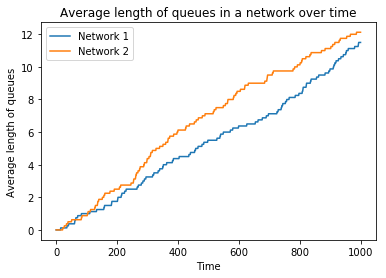

0.0115115115115
0.0121371371371


In [380]:
total_time=1000
# matrix of queue lengths for each commodity
queues_k1=[np.zeros(N[0]),np.zeros(N[1])]
queues_k2=[np.zeros(N[0]),np.zeros(N[1])]

# period length
T=50

#average queue length measure for each time slot, for each network
ave_queue=np.zeros((G,total_time))

for time in range(0,total_time):
    # every period, reset the interferences
    if (time % T ==0):
        # initialize the interference links matrix
        # 0 means no interference, 1 means interference
        # the size of this matrix is the number of links in network 1 by number of links in network 2
        interf_links_01=np.random.choice(2, (num_links[0],num_links[1]))

    # the first is the interferences between networks 0 and 1
    interf_links=[interf_links_01]
    interf_nets=[(0,1)]

    control=[np.zeros((N[0],N[0])),np.zeros((N[1],N[1]))]
    commodity=[np.zeros((N[0],N[0])),np.zeros((N[1],N[1]))]
    state=intra_links

    # update the queue lengths at each time step
    # find each networks optimal control decision using backpressure
    # the control is how many packets to send along a link, commodity is which commodity to send
    for net in range(0,G):
        control[net], commodity[net]=backpressure(state[net],queues_k1[net],queues_k2[net])

    # choose which frequency to send along
    # random frequency generator - there are 2 frequencies freq=0 or 1 that each channel picks randomly
    freq_net0=np.random.choice(2, (N[0],N[0]))
    freq_net1=np.random.choice(2, (N[1],N[1]))
    freq=[freq_net0, freq_net1]

    # create an interference matrix where 0 is interference and 1 is not
    interference_freq1, interference_freq2=find_interferences(control,freq,interf_links,interf_nets,link_indices)

    # move packets along unless there are interferences
    # packet_movement function updates the queues
    queues_k1, queues_k2=packet_movement(queues_k1,queues_k2,control,commodity,freq,interference_freq1,interference_freq2)

    # add the outside arrivals
    queues_k1=add_arrivals(queues_k1, arrivals_k1)
    queues_k2=add_arrivals(queues_k2, arrivals_k2)

    # find the average queue lengths for each network
    for net in range(0,G):
        ave_queue[net,time]=np.mean(np.concatenate((queues_k1[net],queues_k2[net]), axis=0))

pl=np.arange(0,total_time,1)
plt.figure()
plt.plot(pl,ave_queue[0],label='Network 1')
plt.plot(pl,ave_queue[1],label='Network 2')
plt.ylabel('Average length of queues')
plt.xlabel('Time')
plt.legend()
plt.title('Average length of queues in a network over time')
plt.show()

ave_queue_change=[(sum(ave_queue[0,range(1,len(ave_queue[0]))]-ave_queue[0,range(0,len(ave_queue[0])-1)]))/(total_time-1),(sum(ave_queue[1,range(1,len(ave_queue[0]))]-ave_queue[1,range(0,len(ave_queue[0])-1)]))/(total_time-1)]

print(ave_queue_change[0])
print(ave_queue_change[1])

In [332]:
np.random.choice(2,1)[0]

1

In [413]:
def standard_algorithm():
    total_time=1000
    # matrix of queue lengths for each commodity
    queues_k1=[np.zeros(N[0]),np.zeros(N[1])]
    queues_k2=[np.zeros(N[0]),np.zeros(N[1])]

    # period length
    T=50

    #average queue length measure for each time slot, for each network
    ave_queue=np.zeros((G,total_time))

    for time in range(0,total_time):
        # every period, reset the interferences
        if (time % T ==0):
            # initialize the interference links matrix
            # 0 means no interference, 1 means interference
            # the size of this matrix is the number of links in network 1 by number of links in network 2
#             interf_links_01=np.random.choice(2, (num_links[0],num_links[1]))
            interf_links_01=np.zeros((num_links[0],num_links[1]))

        # the first is the interferences between networks 0 and 1
        interf_links=[interf_links_01]
        interf_nets=[(0,1)]

        control=[np.zeros((N[0],N[0])),np.zeros((N[1],N[1]))]
        commodity=[np.zeros((N[0],N[0])),np.zeros((N[1],N[1]))]
        state=intra_links

        # update the queue lengths at each time step
        # find each networks optimal control decision using backpressure
        # the control is how many packets to send along a link, commodity is which commodity to send
        for net in range(0,G):
            control[net], commodity[net]=backpressure(state[net],queues_k1[net],queues_k2[net])

        # choose which frequency to send along
        # random frequency generator - there are 2 frequencies freq=0 or 1 that each channel picks randomly
        freq_net0=np.random.choice(2, (N[0],N[0]))
        freq_net1=np.random.choice(2, (N[1],N[1]))
        freq=[freq_net0, freq_net1]

        # create an interference matrix where 0 is interference and 1 is not
        interference_freq1, interference_freq2=find_interferences(control,freq,interf_links,interf_nets,link_indices)

        # move packets along unless there are interferences
        # packet_movement function updates the queues
        queues_k1, queues_k2=packet_movement(queues_k1,queues_k2,control,commodity,freq,interference_freq1,interference_freq2)

        # add the outside arrivals
        queues_k1=add_arrivals(queues_k1, arrivals_k1)
        queues_k2=add_arrivals(queues_k2, arrivals_k2)

        # find the average queue lengths for each network
        for net in range(0,G):
            ave_queue[net,time]=np.mean(np.concatenate((queues_k1[net],queues_k2[net]), axis=0))

#     pl=np.arange(0,total_time,1)
#     plt.figure()
#     plt.plot(pl,ave_queue[0],label='Network 1')
#     plt.plot(pl,ave_queue[1],label='Network 2')
#     plt.ylabel('Average length of queues')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('Average length of queues in a network over time')
#     plt.show()

    ave_queue_change=[(sum(ave_queue[0,range(1,len(ave_queue[0]))]-ave_queue[0,range(0,len(ave_queue[0])-1)]))/(total_time-1),(sum(ave_queue[1,range(1,len(ave_queue[0]))]-ave_queue[1,range(0,len(ave_queue[0])-1)]))/(total_time-1)]

#     print(ave_queue_change[0])
#     print(ave_queue_change[1])
    return ave_queue_change

Given this problem and the standard use of backpressure, let's see what the capacity region is.  We will say that the networks were able to stabilize if the average change in queues is close to zero.  From inspection, if the average change in queue length is less than 0.003, then the network is stable.

In [ ]:
# for each lambda 1, lambda 2 pair, run trials and test whether the system stabilized for all 
# since there is randomness in the system, we need to run over multiple trials

# how much we'll change the value of lambda after testing
delta=0.02
# start with both lambdas at 0
lambda1=0
lambda2=0
# when stop = 0, keep increasing, when = 1, then stop
lambda1_stop=0
lambda2_stop=0

# number of trials to run for each lambda
trials=20

plt.figure()

while (lambda1_stop==0):
    # outside arrival probability matrix for each node in the networks (probability that a packet arrives)
    # for each commodity 
    arrivals_k1=[np.zeros(N[0]),np.zeros(N[1])]
    arrivals_k2=[np.zeros(N[0]),np.zeros(N[1])]
    # only the first node gets outside arrivals
    for j in range(0,len(arrivals_k1)):
        arrivals_k1[j][0]=lambda1
        arrivals_k2[j][0]=lambda2
    
    unstable=0
    for trial in range(trials):
        trial_queue_change=standard_algorithm()
        if trial_queue_change[0]>0.003 or trial_queue_change[1]>0.003:
            unstable=1
    
    # if the trials yield one unstable, stop increasing lambda 
    # else plot the point as inside the capacity region and increase lambda
    if unstable==1:
        lambda1_stop=1
        max_lambda1=lambda1
    else:
        plt.plot(lambda1,lambda2,"s",color='b')
        lambda1=lambda1+delta

lambda1=0
while (lambda2_stop==0):
    # outside arrival probability matrix for each node in the networks (probability that a packet arrives)
    # for each commodity 
    arrivals_k1=[np.zeros(N[0]),np.zeros(N[1])]
    arrivals_k2=[np.zeros(N[0]),np.zeros(N[1])]
    # only the first node gets outside arrivals
    for j in range(0,len(arrivals_k1)):
        arrivals_k1[j][0]=lambda1
        arrivals_k2[j][0]=lambda2
    
    unstable=0
    for trial in range(trials):
        trial_queue_change=standard_algorithm()
        if trial_queue_change[0]>0.003 or trial_queue_change[1]>0.003:
            unstable=1
    
    # if the trials yield one unstable, stop increasing lambda 
    # else plot the point as inside the capacity region and increase lambda
    if unstable==1:
        lambda2_stop=1
        max_lambda2=lambda2
    else:
        plt.plot(lambda1,lambda2,"s",color='b')
        lambda2=lambda2+delta

        
lambda1_range=np.arange(0,max_lambda1+delta,delta)
lambda2_range=np.arange(0,max_lambda1+delta,delta)
for i in range(0,len(lambda1_range)):
    for k in range(0,len(lambda2_range)):
        # outside arrival probability matrix for each node in the networks (probability that a packet arrives)
        # for each commodity 
        arrivals_k1=[np.zeros(N[0]),np.zeros(N[1])]
        arrivals_k2=[np.zeros(N[0]),np.zeros(N[1])]
        # only the first node gets outside arrivals
        for j in range(0,len(arrivals_k1)):
            arrivals_k1[j][0]=lambda1_range[i]
            arrivals_k2[j][0]=lambda2_range[k]

        unstable=0
        for trial in range(trials):
            trial_queue_change=standard_algorithm()
            if trial_queue_change[0]>0.003 or trial_queue_change[1]>0.003:
                unstable=1

        # if the trials yield one unstable, stop increasing lambda 
        # else plot the point as inside the capacity region and increase lambda
        if unstable==0:
            l1=lambda1_range[i]
            l2=lambda2_range[k]
            plt.plot(l1,l2,"s",color='b')


plt.ylabel('Commodity 2 arrival rate')
plt.xlabel('Commodity 1 arrival rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Empirical Capacity Region - no interference')
plt.show()

In [398]:
# gradient descent learning rate testing
# future work adaptive learning rate!

def backpressure_gdtest(state,queues_k1,queues_k2):
    # find the optimal commodity across each link
    # set to 0 if commodity 0 is optimal, 1 if commodity 1 is optimal
    # find the optimal weight across each link
    commodity=np.zeros(state.shape)
    weight=np.zeros(state.shape)
    nodes = state.shape[0]
    for start in range(0,nodes):
        for end in range(0,nodes):
            if state[start,end]>0:
                queues_k1_diff=queues_k1[start]-queues_k1[end]
                queues_k2_diff=queues_k2[start]-queues_k2[end]
                m, n=opt_com_weight(queues_k1_diff,queues_k2_diff)
                commodity[start,end]=m
                weight[start,end]=n
    
    # find all of the different possible control actions
    poss_controls = find_control_actions(state)
    
#     # find the control actions that maximize sum of weights    
    control1=gradient_descent(poss_controls, weight, 1)
    gain1=control_gains(control1,weight)
    control2=gradient_descent(poss_controls, weight, 2)
    gain2=control_gains(control2,weight)
    control3=gradient_descent(poss_controls, weight, 3)
    gain3=control_gains(control3,weight)
    control4=gradient_descent(poss_controls, weight, 4)
    gain4=control_gains(control4,weight)
    
    # find the control actions that maximize sum of weights
    gains=np.zeros(len(poss_controls))
    for c in range(0,len(poss_controls)):
        gains[c]=control_gains(poss_controls[c],weight)
    
    gains=gains.tolist()
    max_value = max(gains)
    max_index = gains.index(max_value)
    control=poss_controls[max_index]
    
    return control, commodity, max_value, gain1, gain2, gain3, gain4

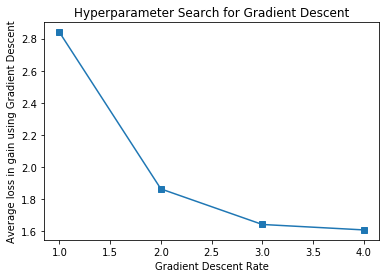

0.0
0.00025025025025


In [412]:
total_time=1000
# matrix of queue lengths for each commodity
queues_k1=[np.zeros(N[0]),np.zeros(N[1])]
queues_k2=[np.zeros(N[0]),np.zeros(N[1])]

# period length
T=50

#average queue length measure for each time slot, for each network
ave_queue=np.zeros((G,total_time))

gain_diff1=0
gain_diff2=0
gain_diff3=0
gain_diff4=0


for time in range(0,total_time):
    # every period, reset the interferences
    if (time % T ==0):
        # initialize the interference links matrix
        # 0 means no interference, 1 means interference
        # the size of this matrix is the number of links in network 1 by number of links in network 2
        interf_links_01=np.random.choice(2, (num_links[0],num_links[1]))

    # the first is the interferences between networks 0 and 1
    interf_links=[interf_links_01]
    interf_nets=[(0,1)]

    control=[np.zeros((N[0],N[0])),np.zeros((N[1],N[1]))]
    commodity=[np.zeros((N[0],N[0])),np.zeros((N[1],N[1]))]
    state=intra_links

    # update the queue lengths at each time step
    # find each networks optimal control decision using backpressure
    # the control is how many packets to send along a link, commodity is which commodity to send
    for net in range(0,G):
        control[net], commodity[net],max_value,gain1,gain2,gain3,gain4=backpressure_gdtest(state[net],queues_k1[net],queues_k2[net])

    # choose which frequency to send along
    # random frequency generator - there are 2 frequencies freq=0 or 1 that each channel picks randomly
    freq_net0=np.random.choice(2, (N[0],N[0]))
    freq_net1=np.random.choice(2, (N[1],N[1]))
    freq=[freq_net0, freq_net1]

    # create an interference matrix where 0 is interference and 1 is not
    interference_freq1, interference_freq2=find_interferences(control,freq,interf_links,interf_nets,link_indices)

    # move packets along unless there are interferences
    # packet_movement function updates the queues
    queues_k1, queues_k2=packet_movement(queues_k1,queues_k2,control,commodity,freq,interference_freq1,interference_freq2)

    # add the outside arrivals
    queues_k1=add_arrivals(queues_k1, arrivals_k1)
    queues_k2=add_arrivals(queues_k2, arrivals_k2)

    # find the average queue lengths for each network
    for net in range(0,G):
        ave_queue[net,time]=np.mean(np.concatenate((queues_k1[net],queues_k2[net]), axis=0))
    
    gain_diff1=gain_diff1+(max_value-gain1)
    gain_diff2=gain_diff2+(max_value-gain2)
    gain_diff3=gain_diff3+(max_value-gain3)
    gain_diff4=gain_diff4+(max_value-gain4)

gain_diff1=gain_diff1/total_time  
gain_diff2=gain_diff2/total_time  
gain_diff3=gain_diff3/total_time  
gain_diff4=gain_diff4/total_time    

gains=[gain_diff1, gain_diff2, gain_diff3, gain_diff4]
x = [1,2,3,4]

plt.figure()
# plt.plot(1,gain_diff1,'-s')
# plt.plot(2,gain_diff2,'-s')
# plt.plot(3,gain_diff3,'-s')
# plt.plot(4,gain_diff4,'-s')
plt.plot(x,gains,'-s')
plt.ylabel('Average loss in gain using Gradient Descent')
plt.xlabel('Gradient Descent Rate')
plt.title('Hyperparameter Search for Gradient Descent')
plt.show()

ave_queue_change=[(sum(ave_queue[0,range(1,len(ave_queue[0]))]-ave_queue[0,range(0,len(ave_queue[0])-1)]))/(total_time-1),(sum(ave_queue[1,range(1,len(ave_queue[0]))]-ave_queue[1,range(0,len(ave_queue[0])-1)]))/(total_time-1)]

print(ave_queue_change[0])
print(ave_queue_change[1])